## Part 1 ‐ Exploratory data analysis
Task: The attached logins.json file contains (simulated) login_times of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

with open('logins.json', 'r') as file:
    data = json.load(file)

In [3]:
df = pd.DataFrame(data)

In [4]:
df

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
...,...
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38


In [5]:
df.dtypes

login_time    object
dtype: object

In [6]:
df['login_time'] = pd.to_datetime(df['login_time'])

In [7]:
df.describe()

,login_time
count,93142
mean,1970-02-26 19:09:39.779648278
min,1970-01-01 20:12:16
25%,1970-02-04 10:37:19.750000
50%,1970-03-01 06:33:05.500000
75%,1970-03-22 04:01:10.750000
max,1970-04-13 18:57:38


Time range is for 3.5 months in 1970 starting with January 1st.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


## Create features to examine

In [11]:
# Aggregate into 15-minute intervals
df["rounded_time"] = df["login_time"].dt.floor("15min")
aggregated = df.groupby("rounded_time").size().reset_index(name="login_count")

# Add time features
aggregated["day_of_week"] = aggregated["rounded_time"].dt.day_name()
aggregated["time_of_day"] = aggregated["rounded_time"].dt.strftime("%H:%M")
aggregated["is_weekend"] = aggregated["day_of_week"].isin(["Saturday", "Sunday"])
aggregated["hour"] = aggregated["rounded_time"].dt.hour
aggregated["date"] = aggregated["rounded_time"].dt.date

In [12]:
df

,login_time,rounded_time
0,1970-01-01 20:13:18,1970-01-01 20:00:00
1,1970-01-01 20:16:10,1970-01-01 20:15:00
2,1970-01-01 20:16:37,1970-01-01 20:15:00
3,1970-01-01 20:16:36,1970-01-01 20:15:00
4,1970-01-01 20:26:21,1970-01-01 20:15:00
...,...,...
93137,1970-04-13 18:50:19,1970-04-13 18:45:00
93138,1970-04-13 18:43:56,1970-04-13 18:30:00
93139,1970-04-13 18:54:02,1970-04-13 18:45:00
93140,1970-04-13 18:57:38,1970-04-13 18:45:00


In [13]:
aggregated

,rounded_time,login_count,day_of_week,time_of_day,is_weekend,hour,date
0,1970-01-01 20:00:00,2,Thursday,20:00,False,20,1970-01-01
1,1970-01-01 20:15:00,6,Thursday,20:15,False,20,1970-01-01
2,1970-01-01 20:30:00,9,Thursday,20:30,False,20,1970-01-01
3,1970-01-01 20:45:00,7,Thursday,20:45,False,20,1970-01-01
4,1970-01-01 21:00:00,1,Thursday,21:00,False,21,1970-01-01
...,...,...,...,...,...,...,...
9376,1970-04-13 17:45:00,5,Monday,17:45,False,17,1970-04-13
9377,1970-04-13 18:00:00,5,Monday,18:00,False,18,1970-04-13
9378,1970-04-13 18:15:00,2,Monday,18:15,False,18,1970-04-13
9379,1970-04-13 18:30:00,7,Monday,18:30,False,18,1970-04-13


See if there are any 15 minute interval with zero log ins

In [15]:
# Create full timeline
all_intervals = pd.date_range(start=df["login_time"].min().floor("15min"), end=df["login_time"].max(), freq="15min")
full_df = pd.DataFrame({"rounded_time": all_intervals})
full_df = full_df.merge(aggregated[['rounded_time', 'login_count']], how="left", on="rounded_time")                                                          

In [16]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9788 entries, 0 to 9787
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   rounded_time  9788 non-null   datetime64[ns]
 1   login_count   9381 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 153.1 KB


### There are about 400 intervals in the time range with zero log ins. Fill in the dataframe with a zero count.

In [18]:
full_df["login_count"] = full_df["login_count"].fillna(0)
full_df["date"] = full_df["rounded_time"].dt.date
full_df

,rounded_time,login_count,date
0,1970-01-01 20:00:00,2.0,1970-01-01
1,1970-01-01 20:15:00,6.0,1970-01-01
2,1970-01-01 20:30:00,9.0,1970-01-01
3,1970-01-01 20:45:00,7.0,1970-01-01
4,1970-01-01 21:00:00,1.0,1970-01-01
...,...,...,...
9783,1970-04-13 17:45:00,5.0,1970-04-13
9784,1970-04-13 18:00:00,5.0,1970-04-13
9785,1970-04-13 18:15:00,2.0,1970-04-13
9786,1970-04-13 18:30:00,7.0,1970-04-13


### Examine how the interval count is distributed over the timeline.

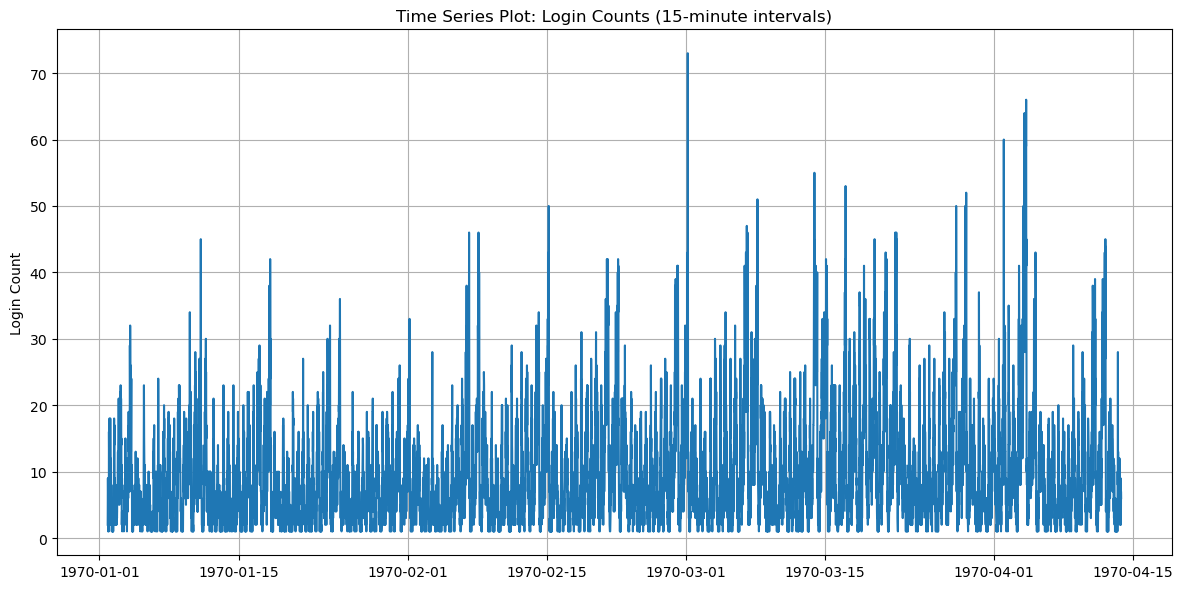

In [20]:
# 1. Time Series Plot
plt.figure(figsize=(12,6))
plt.plot(aggregated["rounded_time"], aggregated["login_count"])
plt.title("Time Series Plot: Login Counts (15-minute intervals)")
plt.ylabel("Login Count")
plt.grid(True)
plt.tight_layout()
plt.show()

There is a pattern of seasonality. Appears to be a weekly pattern. First examine the count trend average during a day cycle.

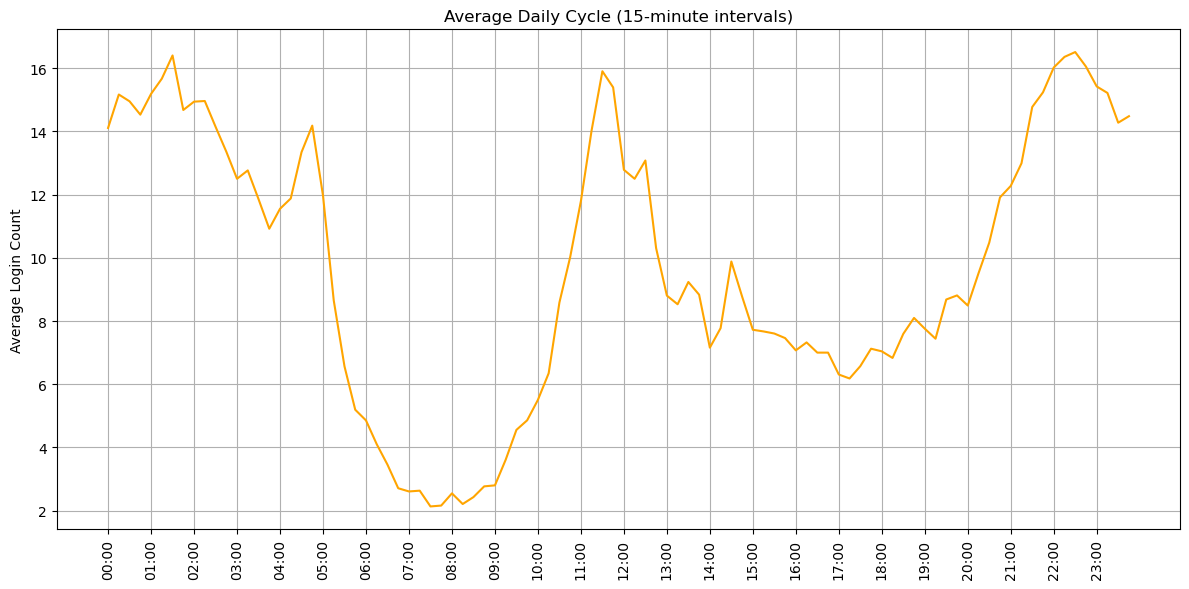

In [22]:
# 2. Daily Cycle Analysis
daily_cycle = aggregated.groupby("time_of_day")["login_count"].mean().reset_index(name="mean_count")
plt.figure(figsize=(12,6))
plt.plot(daily_cycle["time_of_day"], daily_cycle["mean_count"], color="orange")
plt.xticks(ticks=range(0, len(daily_cycle), 4), rotation=90)
plt.title("Average Daily Cycle (15-minute intervals)")
plt.ylabel("Average Login Count")
plt.grid(True)
plt.tight_layout()
plt.show()

There is peak in logins during the lunch hours and night hours. Let's see how that trend behaves between weekdays and weekends.

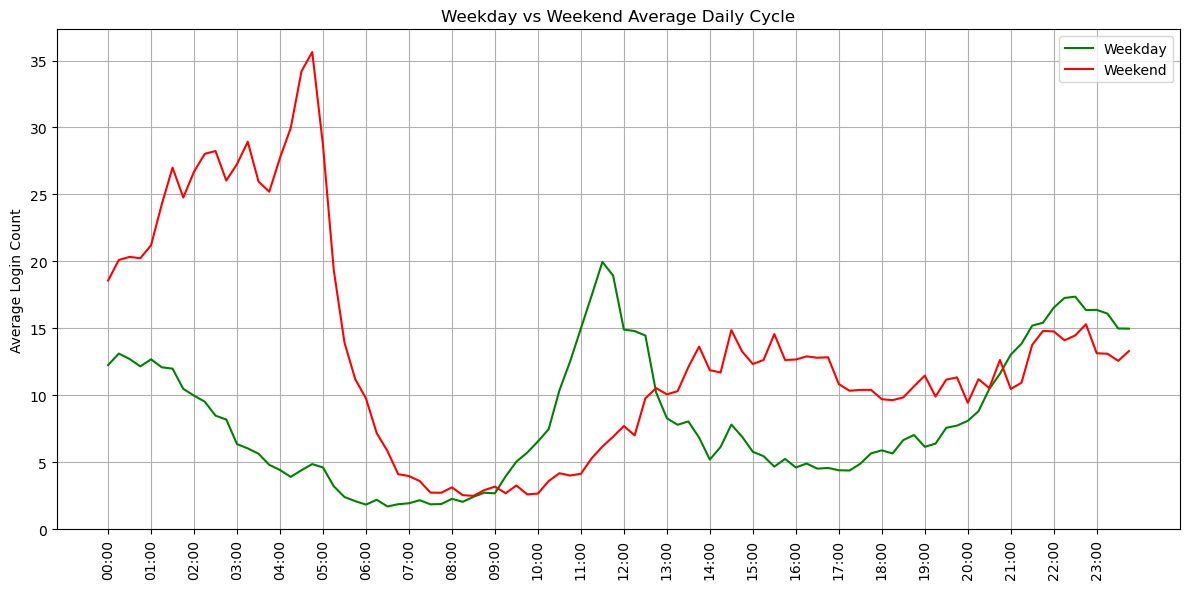

In [24]:
# 3. Weekday vs Weekend Comparison
weekday_cycle = aggregated[~aggregated["is_weekend"]].groupby("time_of_day")["login_count"].mean().reset_index()
weekend_cycle = aggregated[aggregated["is_weekend"]].groupby("time_of_day")["login_count"].mean().reset_index()
plt.figure(figsize=(12,6))
plt.plot(weekday_cycle["time_of_day"], weekday_cycle["login_count"], label="Weekday", color="green")
plt.plot(weekend_cycle["time_of_day"], weekend_cycle["login_count"], label="Weekend", color="red")
plt.xticks(ticks=range(0, len(daily_cycle), 4), rotation=90)
plt.title("Weekday vs Weekend Average Daily Cycle")
plt.ylabel("Average Login Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Weekday is the main contributor for the peak at lunch and the weekends the main contributor for the peak at night.

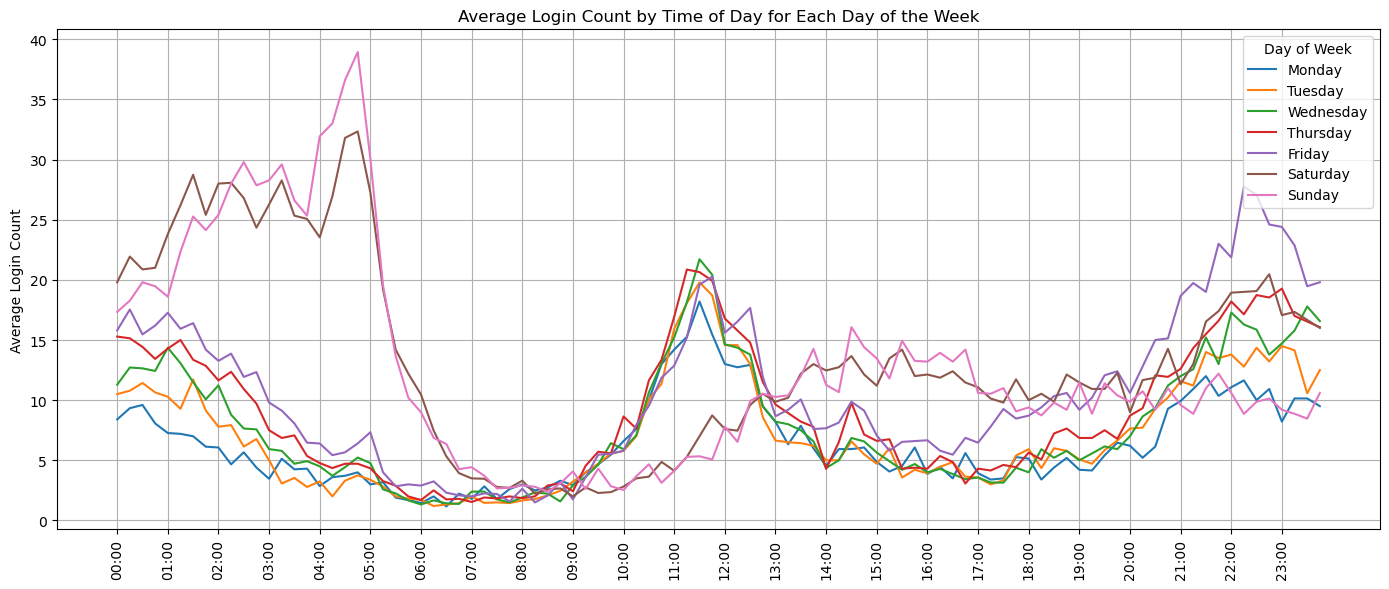

In [26]:
# 4. Breakdown by Day of Week

days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

plt.figure(figsize=(14, 6))

# Loop through each day and plot its average login count by time_of_day
for day in days:
    data_day = aggregated[aggregated["day_of_week"] == day].groupby("time_of_day")["login_count"].mean().reset_index()
    plt.plot(data_day["time_of_day"].astype(str), data_day["login_count"], label=day)

plt.title("Average Login Count by Time of Day for Each Day of the Week")
plt.ylabel("Average Login Count")
plt.xticks(ticks=range(0, len(daily_cycle), 4), rotation=90)
plt.legend(title="Day of Week", loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


Break the day cycle down per day shows most weekdays and weekends days for each others pattern with the exception of between 0:00 and 4:00 for weekdays and between 17:00 and 23:00 for Friday.

Back to examining the overall trend. Lets see if there is a general trend across the timeline and if there are days with abnormally high logins.

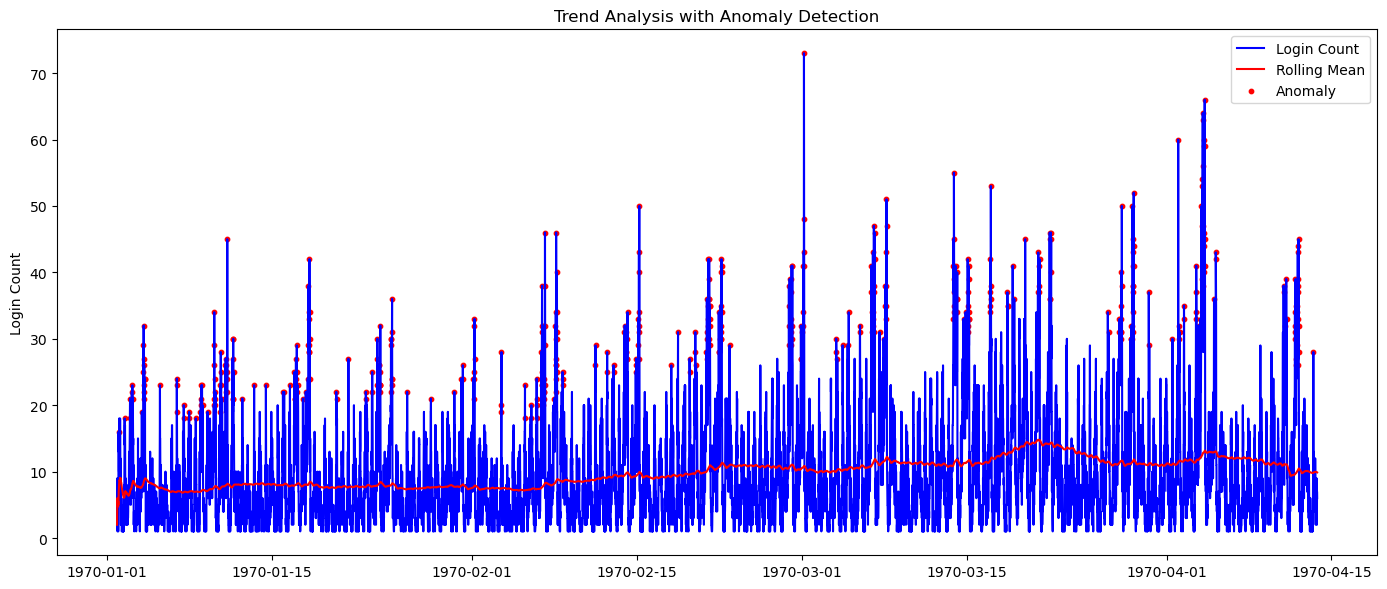

In [29]:
# 4. Trend Analysis and Anomaly Detection
aggregated["rolling_mean"] = aggregated["login_count"].rolling(window=672, min_periods=1).mean()
aggregated["rolling_std"] = aggregated["login_count"].rolling(window=672, min_periods=1).std()
aggregated["anomaly_flag"] = (np.abs(aggregated["login_count"] - aggregated["rolling_mean"]) > 2 * aggregated["rolling_std"]).astype(int)
plt.figure(figsize=(14,6))
plt.plot(aggregated["rounded_time"], aggregated["login_count"], label="Login Count", color="blue")
plt.plot(aggregated["rounded_time"], aggregated["rolling_mean"], label="Rolling Mean", color="red")
plt.scatter(aggregated.loc[aggregated["anomaly_flag"]==1, "rounded_time"],
            aggregated.loc[aggregated["anomaly_flag"]==1, "login_count"],
            color="red", s=10, label="Anomaly")
plt.title("Trend Analysis with Anomaly Detection")
plt.ylabel("Login Count")
plt.legend()
plt.tight_layout()
plt.show()

There is a generally positive or increasing trend of logins over time. 

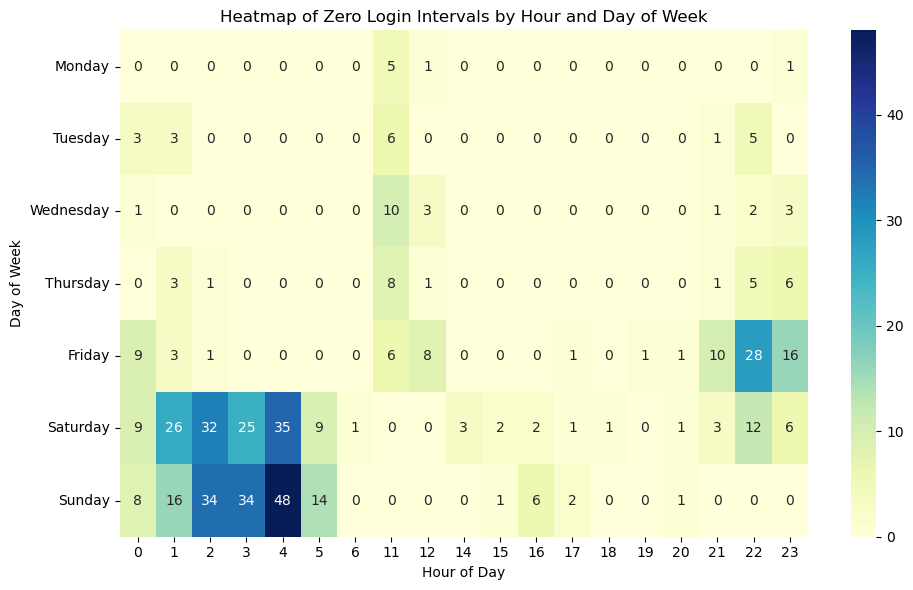

In [31]:
# 8: Heatmap of anomaly login intervals by hour and day of week
anomalies = aggregated[aggregated["anomaly_flag"] == 1]
heatmap_data = anomalies.groupby(["day_of_week", "hour"]).size().unstack(fill_value=0)

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

heatmap_data = heatmap_data.reindex(day_order)
plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt="d")
plt.title("Heatmap of Zero Login Intervals by Hour and Day of Week")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()

The heatmap of the anomally days are a direct correlation to the weekend nights having the most logins.

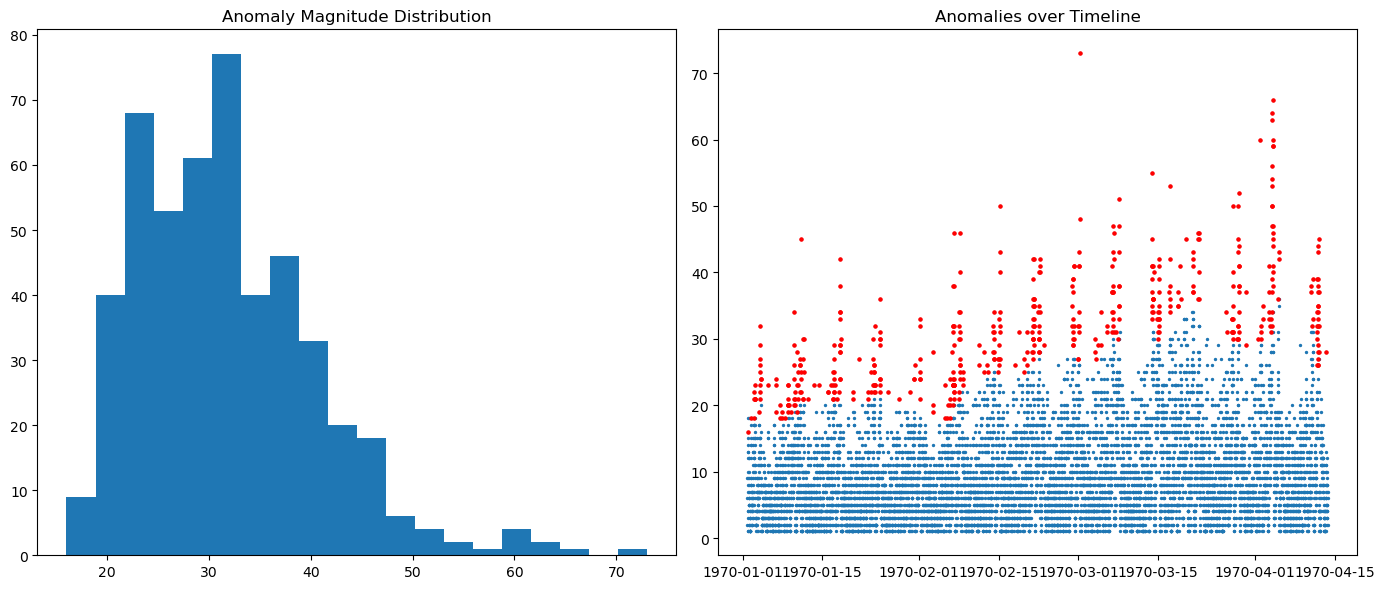

In [33]:
# 5. Anomaly Distribution
anom_magnitude = aggregated[aggregated["anomaly_flag"]==1]["login_count"]
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].hist(anom_magnitude, bins=20)
axes[0].set_title("Anomaly Magnitude Distribution")
axes[1].scatter(aggregated["rounded_time"], aggregated["login_count"], s=2)
axes[1].scatter(aggregated.loc[aggregated["anomaly_flag"]==1, "rounded_time"],
                  aggregated.loc[aggregated["anomaly_flag"]==1, "login_count"],
                  color="red", s=5)
axes[1].set_title("Anomalies over Timeline")
plt.tight_layout()
plt.show()

The scatter plot highlights the weekly seasonality of the high login days, with the histogram showing that most of these high days are around 30 logins. With a right tapering tail to a maximum of 70+ logins in a day.

### Examine pattern is zero login intervals.

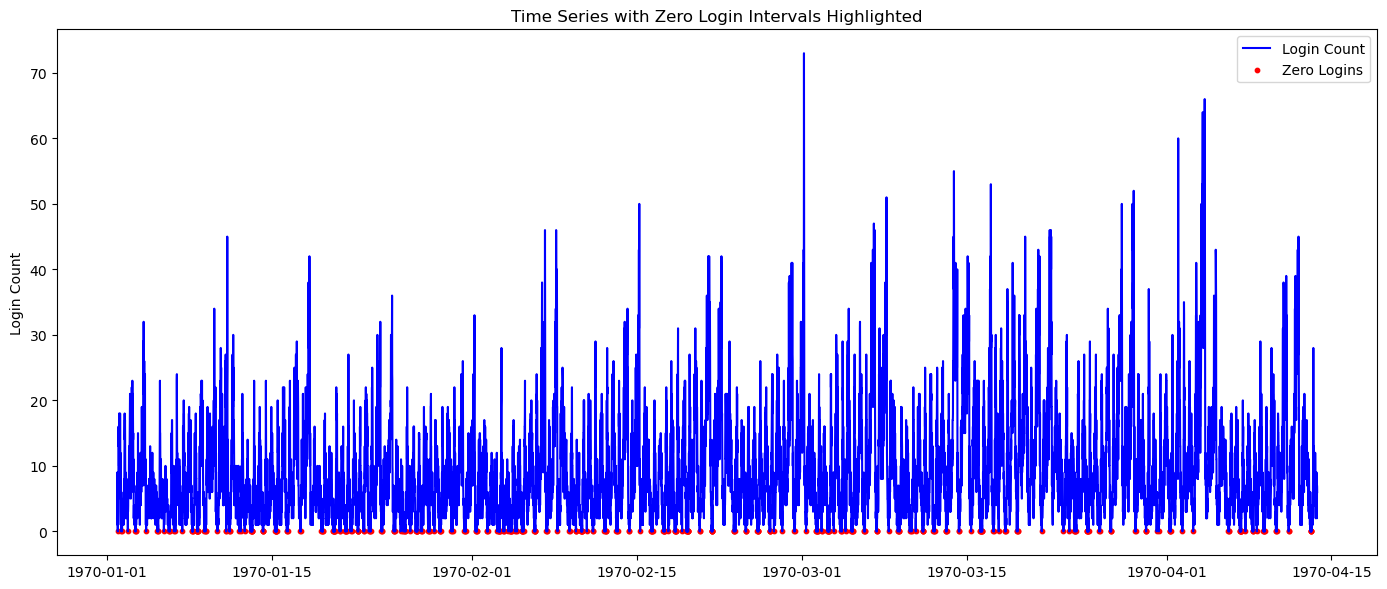

In [36]:
# 6: Time series with zero intervals highlighted
plt.figure(figsize=(14,6))
plt.plot(full_df["rounded_time"], full_df["login_count"], label="Login Count", color="blue")
zero_points = full_df[full_df["login_count"] == 0]
plt.scatter(zero_points["rounded_time"], zero_points["login_count"], color="red", label="Zero Logins", s=10)
plt.title("Time Series with Zero Login Intervals Highlighted")
plt.ylabel("Login Count")
plt.legend()
plt.tight_layout()
plt.show()

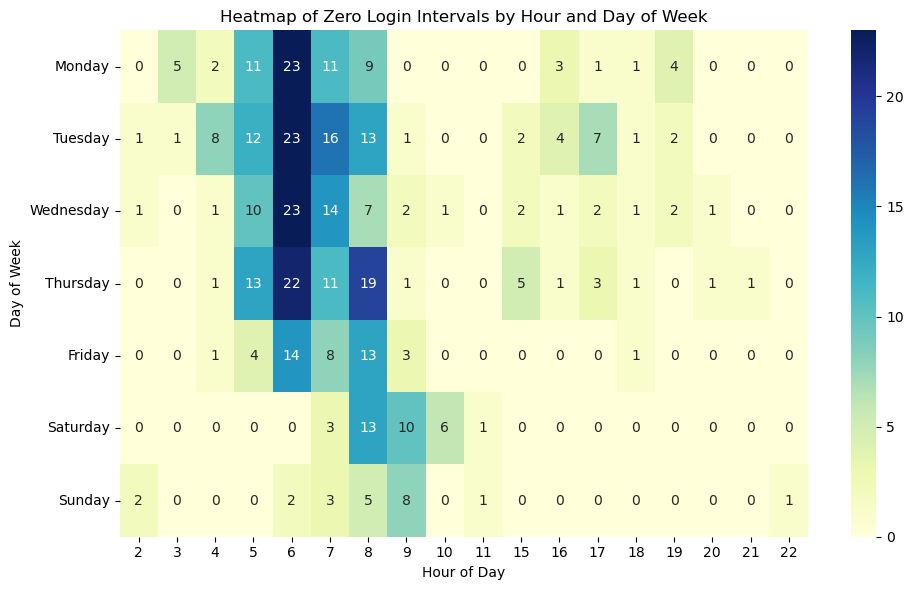

In [37]:
# 7: Heatmap of zero login intervals by hour and day of week
full_df["day_of_week"] = full_df["rounded_time"].dt.day_name()
full_df["hour"] = full_df["rounded_time"].dt.hour
zero_heatmap_data = full_df[full_df["login_count"] == 0].groupby(["day_of_week", "hour"]).size().unstack(fill_value=0)
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
zero_heatmap_data = zero_heatmap_data.reindex(day_order)
plt.figure(figsize=(10,6))
sns.heatmap(zero_heatmap_data, cmap="YlGnBu", annot=True, fmt="d")
plt.title("Heatmap of Zero Login Intervals by Hour and Day of Week")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()

Most of the zero login intervals are Monday thru Thursday between 5:00 and 9:00.

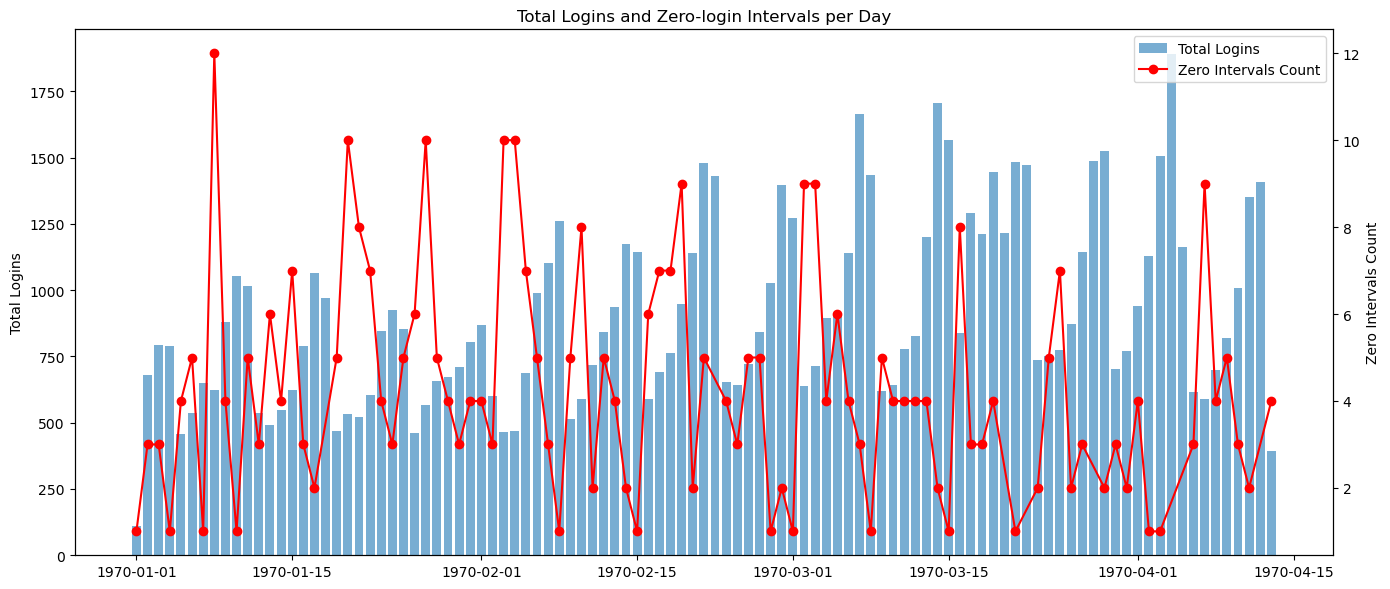

In [39]:
total_by_day = full_df.groupby("date")["login_count"].sum()
zero_intervals = full_df[full_df["login_count"] == 0].groupby("date").size()

fig, ax1 = plt.subplots(figsize=(14, 6))

# Bar plot for total logins
ax1.set_ylabel("Total Logins")
bars = ax1.bar(total_by_day.index, total_by_day.values, alpha=0.6, label="Total Logins")

# Line plot for zero intervals
ax2 = ax1.twinx()
ax2.set_ylabel("Zero Intervals Count")
line, = ax2.plot(zero_intervals.index, zero_intervals.values, color="red", marker="o", label="Zero Intervals Count")

# Combine legends from both axes
lines = [bars, line]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper right")

plt.title("Total Logins and Zero-login Intervals per Day")
fig.tight_layout()
plt.show()


The zero login count per day has weekly pattern that appears to have decreasing peaks over time.

## Conclusion:
The log in count plots highlight popular log in hours and days to be weekday lunches and weekend nights. The general trends seem to support overall popularity increases across the 3.5 month timeline. Quantity the popularity increase would be the next steps after this exploration.